# analysis fastReach 

# 1. general prep


In [1]:

# load packages
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
# %load_ext rpy2.ipython # currently not needed
import glob

from wordcloud import WordCloud, STOPWORDS
#from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import pymer4 as pymer4

#for anova
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.anova import AnovaRM


In [2]:
# set repository
p= "C://Users/terfu/Desktop/2021-fastReach/data/study/" #repository for output

# 2. temporal binding



## prep
### load data

In [3]:
# load data
behavior_raw= pd.read_csv( p + 'PI_results_design.csv')



# set data types
behavior_raw[['ed','rt']] = behavior_raw[['ed','rt']].apply(pd.to_numeric, axis=1)

behavior_raw['rd'] = behavior_raw['rd'].astype("string")  # needs to be string before category for R conversion

behavior_raw[['rd','condition']] = behavior_raw[['rd','condition']].astype("category")


# delete VP 18 (did not follow instructions in block 3)

behavior_raw =  behavior_raw.loc[behavior_raw["id"] !=18]



### check raw data (rection times and estimated times)


(0.0, 5.0)

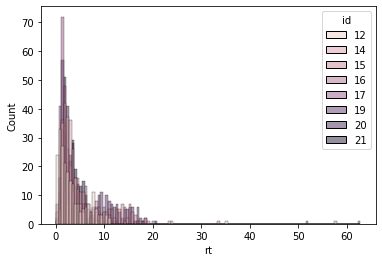

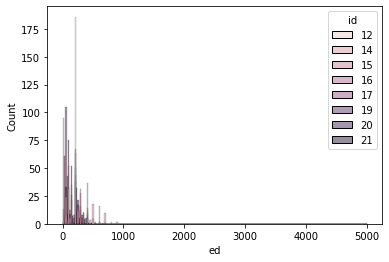

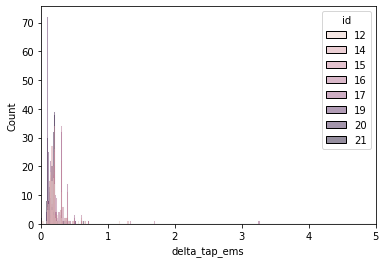

In [4]:
fig, ax = plt.subplots()
hist = sns.histplot(behavior_raw, x = 'rt',ax =ax, hue = 'id')
#ax.set_xlim(0,5) # remove outliers for visualization

fig, ax = plt.subplots()
hist = sns.histplot(behavior_raw, x = 'ed',ax =ax, hue = 'id')


fig, ax = plt.subplots()
hist = sns.histplot(behavior_raw, x = 'delta_tap_ems',ax =ax, hue = 'id')
ax.set_xlim(0,5) # remove outliers for visualization

### clean data

In [5]:
# removes outliers trials that have outliers either in rt or ed
#@Lukas: do we want to remove only extreme or all outliers?

cols = ['rt', 'ed','delta_tap_ems'] # relevant cols

# calculate quantiles and IQR
Q1 = behavior_raw[cols].quantile(0.25) # Same as np.percentile but maps (0,1) and not (0,100)
Q3 = behavior_raw[cols].quantile(0.75)
IQR = Q3 - Q1

# return a boolean array of the rows with (any) non-outlier column values
condition = ~((behavior_raw[cols] < (Q1 - 3 * IQR)) | (behavior_raw[cols] > (Q3 + 3 * IQR))).any(axis=1)

# filter our dataframe based on condition
behavior = behavior_raw[condition]
behavior_del = behavior_raw[-condition]

In [6]:
# check outlier removel

#count deleted trials
print('Deleted trials:',len(behavior_del))

#per pID
print('Deleted trials per pID')
print(behavior_del['id'].value_counts())

print('mean')
print(behavior_del['id'].value_counts().mean())
print('sd')
print(behavior_del['id'].value_counts().std())

#per condition
print('Deleted trials per condition')
print(behavior_del['condition'].value_counts())
print('mean')
print(behavior_del['condition'].value_counts().mean())
print('sd')
print(behavior_del['condition'].value_counts().std())


Deleted trials: 102
Deleted trials per pID
15    37
19    25
16    12
17    10
12     8
14     7
20     3
Name: id, dtype: int64
mean
14.571428571428571
sd
12.067271755415456
Deleted trials per condition
ems_random    53
baseline      25
ems_bci       24
Name: condition, dtype: int64
mean
34.0
sd
16.46207763315433


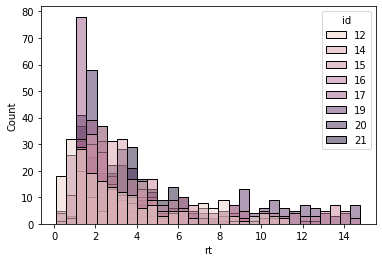

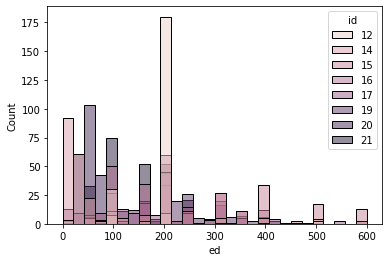

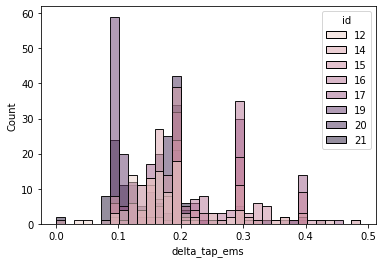

In [7]:
#check new data

fig, ax = plt.subplots()
hist = sns.histplot(behavior, x = 'rt',ax =ax, hue = 'id')
#ax.set_xlim(0,5) # remove outliers for visualization

fig, ax = plt.subplots()
hist = sns.histplot(behavior, x = 'ed',ax =ax, hue = 'id')

fig, ax = plt.subplots()
hist = sns.histplot(behavior, x = 'delta_tap_ems',ax =ax, hue = 'id')


## plot
### prep plot

In [13]:
# with stimulation condition + time condition+ rd as y

behavior[['rd']] = behavior[['rd']].apply(pd.to_numeric, axis=1)
behavior[['ed']] = behavior[['ed']].apply(pd.to_numeric, axis=1)
# diff = ed - 350 because 350 is the mean of the different time intervals; maybe add *-1  to adapt direction of the plot
behavior["diff"]= behavior['ed']-350
behavior[['rd']] = behavior[['rd']].astype("category")


####tbd - change diff to rd-ed to get positive value for understimation
#behavior["diff"] = behavior["diff"]*-1

behavior_means = behavior.groupby(['id','condition'],as_index=False)['diff'].mean()

palette = ['#576683', '#E4f392', '#337775']

cats= ['baseline','ems_random','ems_bci'] 
ylabel = '350-ed'
xlabel = 'condition'
title = 'temporal_binding'
data = behavior
data_means = behavior_means
y = 'diff'
x = "condition"
hue = "id"
hue2 = 'rd'



C:\Users\terfu\AppData\Local\Temp\ipykernel_1968\3597011993.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior[['rd']] = behavior[['rd']].apply(pd.to_numeric, axis=1)
C:\Users\terfu\AppData\Local\Temp\ipykernel_1968\3597011993.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior[['ed']] = behavior[['ed']].apply(pd.to_numeric, axis=1)
C:\Users\terfu\AppData\Local\Temp\ipykernel_1968\3597011993.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


### plot


@ Lukas: double check; does this make sense to you?

 I used diff (ed-rd) as the depent measure. This basically describes the underestimation of the duration between touch and tone. Larger negative values describe larger underestimation, i.e., interval was 200 ms (rd)  but was estimated 100ms (ed), the dependet measure would be -100 ms. A value of 0 depicts a matching estimate. 

We assume that high agency leads to increased underestimation (temporal binding), therewith the baseline should have the lowest vaule, passive the highest (around 0) and agency should be somewhere inbetween. 

Would it make sense to invert the graphic/diff (*-1) - because high in underestimation is connected to high agency = both graphics would go the same direction.


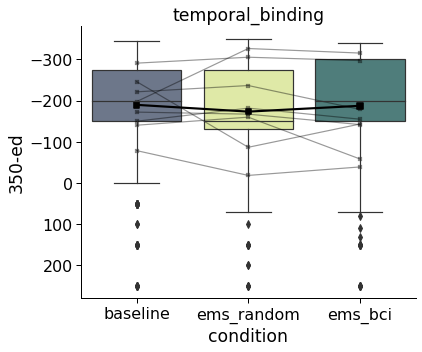

In [18]:
# runs plot but needs post processing in affinty desiger
cats_0 = data[data[x]==cats[0]]
cats_1 = data[data[x]==cats[1]]
cats_2 = data[data[x]==cats[2]]

pairs = [(cats[0], cats[1],cats[2])]


with sns.plotting_context('paper', font_scale = 1.8):

    ### Create new plot
    fig, ax = plt.subplots(1, 1, figsize=(6,5))
    fig.patch.set_alpha(1)

    sns.despine() #bottom=True, left=True

        # show boxplots
    ax = sns.boxplot(data = data,x = x, y = y,  order= ['baseline','ems_random','ems_bci'] ,  palette= palette )
    for patch in ax.patches: # adapt alpha
            r, g, b, a = patch.get_facecolor()
            patch.set_facecolor((r, g, b, .9))

    # show line connecting means
    ax =  sns.pointplot(data = data,x = x, y = y, markers="s",linewidth = 1, size = 6, ci =None,color = 'black',legend = False, order = cats)
    
     #  show lines connecting pid means observations    
    ax = sns.lineplot(data = data_means, x = x, y = y,hue = hue, palette = sns.color_palette(['black'],8),legend = False,alpha=0.4)
    
    ax = sns.scatterplot(data=data_means, x=x, y=y,s=10, legend= True, marker="s",color = 'black',edgecolor = 'black',alpha=0.4)
        
    ax.invert_yaxis()

    handles, labels = ax.get_legend_handles_labels()  
    
    #plt.legend(handles[3:6],labels[3:6],frameon=True,loc = 'upper left',labelspacing =0.3)
    
    # label_plot_for_subcats(ax)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    
    plt.show()

fig.savefig('results/'+title + '_'+'.svg', format='svg', transparent=True, bbox_inches='tight', dpi=300)
fig.savefig('results/'+title + '_' +'.png', format='png', transparent=True, bbox_inches='tight', dpi=300)

## anaysis


### descriptive

In [ ]:
# descreptive
print(behavior.groupby('condition')['diff'].agg(['mean','std']))

#print(behavior.groupby('rd')['diff'].agg(['mean','std']))



                  mean         std
condition                         
baseline   -152.503040  151.844652
ems_bci    -194.112903  121.551708
ems_random -183.693624  124.730567


### LMM

#### prep
- witched from rpy2 to pymer4, because it is less annoying with importing / exporting from python to R
- not sure if of this is still necessary, but since pymer4 is based on rpy2, this might be the case

In [ ]:
packnames = ('lme4', 'lmerTest', 'emmeans', 'geepack', 'sjPlot')
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector
utils = importr("utils")
utils.chooseCRANmirror(ind=1)

<rpy2.rinterface_lib.sexp.NULLType object at 0x0000019E07968840> [RTYPES.NILSXP]

In [ ]:
packnames = ('lme4', 'lmerTest', 'emmeans', 'geepack', 'sjPlot')
from rpy2.robjects.vectors import StrVector
utils.install_packages(StrVector(packnames))
from pymer4.models import Lmer

Paket 'geepack' erfolgreich ausgepackt und MD5 Summen abgeglichen
Paket 'sjPlot' erfolgreich ausgepackt und MD5 Summen abgeglichen




Exception ignored from cffi callback <function _consolewrite_ex at 0x0000019E0792A680>:
Traceback (most recent call last):
  File "c:\Users\terfu\AppData\Local\Programs\Python\Python310\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 133, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
  File "c:\Users\terfu\AppData\Local\Programs\Python\Python310\lib\site-packages\rpy2\rinterface_lib\conversion.py", line 138, in _cchar_to_str_with_maxlen
    s = ffi.string(c, maxlen).decode(encoding)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe4 in position 25: invalid continuation byte


#### built models

In [ ]:
# full model

full_model = Lmer('diff ~ condition + (1|id)', data = behavior)
display(full_model.fit(REML = False,factors={"condition": ["baseline", "ems_random", "ems_bci"]}))
#full_model.plot_summary()

c:\Users\terfu\AppData\Local\Programs\Python\Python310\lib\site-packages\rpy2\robjects\pandas2ri.py:65: UserWarning: Error while trying to convert the column "rd". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '


RRuntimeError: Error in eval(predvars, data, env) : object 'pID' not found



#### define null models

In [ ]:

# null model without stimulation condition 
null_model = Lmer('diff ~ (1|id)', data = behavior)
null_model.fit(REML = False, summarize=False)


c:\Users\terfu\AppData\Local\Programs\Python\Python310\lib\site-packages\rpy2\robjects\pandas2ri.py:65: UserWarning: Error while trying to convert the column "rd". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '


**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.



#### liklyhood ratio tests



stimulation condition

In [ ]:
pymer4.stats.lrt([null_model,full_model])

,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,diff~(1|id),3,23635.321882,23652.003686,-11814.660941,23629.321882,,,,
1,diff~condition+(1|id),5,23596.007993,23623.810998,-11793.003996,23586.007993,43.31389,2.0,0.0,***


temp condition

#### post hoc test

TODO check wether this post_hoc test is correct


 @Lukas: Hier bin ich mir nicht sicher, ob man d as einfach so machen kann. Bzw. Also pairwise t-test mit dem full model. 
- in dem 2019 CPS Paper wird die Quelle verwendet für post-hoc test
 check - Wilcoxon, F.: Individual comparisons by ranking methods. Biom. Bull. 1(6), 80
(1945) 
- der code kommt von hier:  http://eshinjolly.com/pymer4/auto_examples/example_03_posthoc.html



In [ ]:
# post hoc test condition
marginal_estimates, comparisons = full_model.post_hoc(
    marginal_vars="condition",p_adjust = "bonf")

print(comparisons)


P-values adjusted by bonf method for 3 comparisons
                Contrast  Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  \
1     baseline - ems_bci    39.047  24.106   53.987  6.235  1912.355   6.262   
2  baseline - ems_random    30.319  15.572   45.066  6.154  1912.006   4.926   
3   ems_bci - ems_random    -8.728 -23.750    6.294  6.269  1912.337  -1.392   

   P-val  Sig  
1  0.000  ***  
2  0.000  ***  
3  0.492       


# 3. subjective data



In [21]:
questionaire= pd.read_excel(p + 'questionaire.xlsx') 

good_pid = ['12', '14', '15', '16', '17', '19', '20', '21']
questionaire['pID'] = questionaire['pID'].astype(str)
questionaire = questionaire.loc[questionaire['pID'].isin(good_pid)]


questionaire_long = questionaire.melt(id_vars= ['pID'],value_vars=['baseline','passive','agency'])

c:\Users\terfu\AppData\Local\Programs\Python\Python310\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


### plot control

In [22]:
palette = ['#576683', '#E4f392', '#337775']
cats= ['item_baseline', 'item_passive', 'item_agency']
ylabel = 'level of control'
xlabel = 'condition'
title = 'subjective control rating'
data = questionaire_long
y = 'value'
x = 'variable'
hue = 'pID'

#cohend(data,x,y, cats)

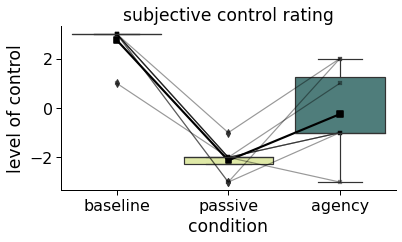

In [23]:
#adapt

with sns.plotting_context('paper', font_scale = 1.8):

        ### Create new plot
        fig, ax = plt.subplots(1, 1, figsize=(6,3))
        fig.patch.set_alpha(1)

        sns.despine() #bottom=True, left=True
         # show boxplots
        ax = sns.boxplot(data = data, x = x, y = y,  palette= palette)
        for patch in ax.patches: # adapt alpha
             r, g, b, a = patch.get_facecolor()
             patch.set_facecolor((r, g, b, .9))

                   
        # show line connecting means
        sns.pointplot(
            data = data,x = x, y = y,
            markers="s",linewidth = 1, size = 6, ci =None,color = 'black',legend = False)
        
        # pId means
        
        ax = sns.lineplot(data = data, x = x, y = y,hue = hue, palette = sns.color_palette(['black'],8),legend = False,alpha=0.4)
    
        ax = sns.scatterplot(data=data, x=x, y=y,s=10, legend= True, marker="s",color = 'black',edgecolor = 'black',alpha=0.4)

        #sns.scatterplot(data = data,x = x, y = y, markers="^",color = 'black')


        
        # Label and show
        # label_plot_for_subcats(ax)
        ax.set_title(title)
        ax.set_ylabel(ylabel)
        ax.set_xlabel(xlabel)

      

        plt.show()
        fig.savefig('results/'+title + '_' +'.svg', format='svg', transparent=True, bbox_inches='tight', dpi=300)
        fig.savefig('results/'+title + '_' +'.png', format='png', transparent=True, bbox_inches='tight', dpi=300)

#### LME


In [ ]:
#full model
full_model = Lmer('value ~ variable + (1|pID)', data = questionaire_long)
display(full_model.fit(REML = False,factors={"variable": ["baseline", "passive", "agency"]}))


boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: value~variable+(1|pID)

Family: gaussian	 Inference: parametric

Number of observations: 24	 Groups: {'pID': 8.0}

Log-likelihood: -35.851 	 AIC: 81.701

Random effects:

                 Name    Var    Std
pID       (Intercept)  0.000  0.000
Residual               1.161  1.078

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),2.750,2.003,3.497,0.381,24.0,7.217,0.0,***
variable1,-4.875,-5.931,-3.819,0.539,24.0,-9.047,0.0,***
variable2,-3.000,-4.056,-1.944,0.539,24.0,-5.567,0.0,***


In [ ]:
#null model
null_model = Lmer('value ~ (1|pID)', data = questionaire_long)
null_model.fit(REML = False, summarize=False)

boundary (singular) fit: see help('isSingular') 



In [ ]:
# liklyhood ratio test
pymer4.stats.lrt([null_model,full_model])

,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,value~(1|pID),3,113.643179,117.177341,-53.821590,107.643179,,,,
1,value~variable+(1|pID),5,81.701283,87.591552,-35.850642,71.701283,35.941896,2.0,0.0,***


In [ ]:

# post hoc test condition
marginal_estimates, comparisons = full_model.post_hoc(
    marginal_vars="variable",p_adjust = "bonf")

print(comparisons)

P-values adjusted by bonf method for 3 comparisons
             Contrast  Estimate  2.5_ci  97.5_ci     SE    DF  T-stat  P-val  \
1  baseline - passive     4.875   3.488    6.262  0.539  24.0   9.047  0.000   
2   baseline - agency     3.000   1.613    4.387  0.539  24.0   5.567  0.000   
3    passive - agency    -1.875  -3.262   -0.488  0.539  24.0  -3.480  0.006   

   Sig  
1  ***  
2  ***  
3   **  


# 3. Content Analysis
--> not yet adapted to new file format
- built to world clouds for each block
- define stopwords
- maybe check sentiment analysis -> pareid t-test?
-TODO: try word cloud german


In [ ]:
interview_baseline = questionaire['text_baseline'].dropna().to_json(force_ascii = False)

interview_passive = questionaire['text_passive'].dropna().to_json(force_ascii = False)

interview_agency = questionaire['text_agency'].dropna().to_json(force_ascii = False)

stopwords = STOPWORDS # extend by domaine specific words if necessary

interview_baseline2 = questionaire['text_baseline'].dropna().to_string(force_ascii = False)

In [ ]:
#todo check the difference to this code

interview_baseline2 = questionaire['text_baseline'].dropna().to_string()

In [ ]:
print(interview_baseline2)

0    I chose to press the screen; I was using my fr...
1    Ich hatte kein Strom Gefühl; Hätte ich nicht g...
2    Es war  nicht manipuliert; ich habe ausgewählt...


In [ ]:
wc_formate = WordCloud(background_color='black', max_words=500, width=3000,
                    height=1500, stopwords=stopwords, min_font_size=2,
                    contour_width=3, contour_color='white')

wc_formate.generate(interview_baseline2)
wc_formate.to_file(("results/wordcloud_baseline.png"))

wc_formate.generate(interview_passive)
wc_formate.to_file(("results/wordcloud_passive.png"))

wc_formate.generate(interview_passive)
wc_formate.to_file(("results/wordcloud_agency.png"))


# 4. Sentiment Analysis

In [ ]:

analyzer=SentimentIntensityAnalyzer()  

print(analyzer.polarity_scores(interview_baseline))
print(analyzer.polarity_scores(interview_passive))
print(analyzer.polarity_scores(interview_agency))




{'neg': 0.166, 'neu': 0.764, 'pos': 0.07, 'compound': -0.6705}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.323, 'neu': 0.677, 'pos': 0.0, 'compound': -0.9815}
